
# IFT3395/6390 Devoirs 1
> Professeur : Aaron Courville
>
> Étudiants: Zhibin.Lu & Xiaocheng.Liu

## 3. Partie pratique : estimation de densité


In [1]:
%pylab inline
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import utilitaires


Populating the interactive namespace from numpy and matplotlib


### 1).Impl ́ementez un estimateur de densit ́e param ́etrique Gaussien diago- nal. Il devra pouvoir fonctionner pour des donn ́ees de dimension d ar- bitraire. Comme vu dans les labos, il devrait avoir une m ́ethode train pour apprendre les param`etres et une m ́ethode compute predictions qui calcule les log de densit ́e.

In [2]:
# estimateur gauss multivariee
class gauss_mv:
    def __init__(self,n_dims,cov_type="isotropique"):
        self.n_dims = n_dims
        self.mu = np.zeros((1,n_dims))
        self.cov_type = cov_type
        if cov_type=="isotropique":
            self.sigma_sq = 1.0
        elif cov_type=="diagonale":
            self.sigma_sq = numpy.ones(n_dims) 
        elif cov_type=="full":
            self.cov = np.ones((n_dims,n_dims))

    # Pour un ensemble d'entrainement, la fonction devrait calculer l'estimateur par MV de la moyenne et de la matrice de covariance
    def train(self, train_data):
        self.mu = np.mean(train_data, axis=0)
        if self.cov_type == "isotropique": 
            self.sigma_sq = np.sum((train_data - self.mu)**2.0) / (self.n_dims * train_data.shape[0])
        elif self.cov_type == "diagonale": 
            self.sigma_sq =  numpy.sum((train_data - self.mu) ** 2.0, axis = 0) / train_data.shape[0] 
        elif self.cov_type == "full": 
            self.cov = np.cov(np.transpose(train_data))
        print 'mu: ',self.mu
        print 'sigma_sq: ',self.sigma_sq
            
    # Retourne un vecteur de taille nb. ex. de test contenant les log
    # probabilités de chaque exemple de test sous le modèle.   
    def compute_predictions(self, test_data):
        if self.cov_type == "isotropique":
            # log(constante de normalisation)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - self.n_dims*np.log(self.sigma_sq)/2.0 
            # il faut calculer la valeur de la log-probabilite de chaque exemple
            # de test sous le modele determine par mu et sigma_sq. le vecteur
            # des probabilites est/sera log_prob
            log_prob = c - np.sum((test_data -  self.mu)**2.0,axis=1) / (2.0 * self.sigma_sq)
        elif self.cov_type == "diagonale":
            #print self.n_dims,' ',self.mu,' ',self.sigma_sq
            # on prend le produit(乘) du vecteur représentant la diagonale (np.prod(self.sigma)
            c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
            # on somme sur l'axe 1 après avoir divisé par sigma puisque celui ci aussi est
            # de dimension d
            log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)
        elif self.cov_type == "full":
            c = -self.n_dims * np.log(2.0*np.pi)/2.0
            det = np.linalg.det(self.cov) 
            c += np.log(det)/2.0
            
            dmu = test_data-self.mu
            inv = np.linalg.inv(self.cov)
            
            dxs = np.dot(dmu,inv)
            dxsx = np.sum(dxs*dmu,axis=1)
            log_prob = c - dxsx
        return log_prob
    
    # la fonction de probalité de densité de gaussien
    def pdf_normfun(self,x,mu,sigma):
        pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
        #print pdf
        if pdf.size>len(pdf):
            pdf=np.prod(pdf,axis=1)
        return pdf

# test
x=np.array([(1.5,6),(4.2,8)])
t=np.array([(2.3,7.7),(2.9,8.8),(3,6),(4,5),(5,5)])
print 'x ',x
print 't ',t
classg1=gauss_mv(n_dims=2,cov_type="diagonale")
classg1.train(t)
y1=classg1.pdf_normfun(x,classg1.mu,np.sqrt(classg1.sigma_sq))
#print y1

x  [[ 1.5  6. ]
 [ 4.2  8. ]]
t  [[ 2.3  7.7]
 [ 2.9  8.8]
 [ 3.   6. ]
 [ 4.   5. ]
 [ 5.   5. ]]
mu:  [ 3.44  6.5 ]
sigma_sq:  [ 0.9064  2.296 ]


### 2). Implémentez un estimateur de densité de Parzen à noyau Gaussien isotropique. Il devra pouvoir fonctionner pour des données de dimen- sion d arbitraire. De mˆeme il devrait avoir une méthode train pour apprendre les paramètres et une méthode compute predictions qui calcule les log de densité.

In [3]:
# estimateur parzen à noyau gaussienne multivariee isotropique
class estimateur_parzen_a_noyau_gauss_mv_isotropique:
    
    def __init__(self,n_dims,sigma):
        self.n_dims = n_dims
        # hyper parameter sigma
        self.sigma=sigma
        self.sigma_sq = sigma**2

    def train(self, train_data,train_data_class):
        self.train_data=train_data
        self.train_data_class=train_data_class
        self.n_classes=np.unique(train_data_class).shape[0]

    # calculer tous les train_data pour une point de test
    def poids_gauss_mv_isotropique(self,ex):        
        #c = -self.n_dims * np.log(2*np.pi)/2.0 - self.n_dims*np.log(self.sigma_sq)/2.0
        #log_poids = c - np.sum((self.train_data -  ex)**2.0,axis=1) / (2.0 * self.sigma_sq)
        #return log_poids
        #poids = np.exp(-((self.train_data - ex)**2)/(2*self.sigma_sq)) / (self.sigma * np.sqrt(2*np.pi))
        denominateur=self.sigma**self.n_dims * np.sqrt((2*np.pi)**self.n_dims)
        poids=np.exp(-(self.n_dims*np.sum((self.train_data - ex)**2,axis=1)/(2*self.sigma**2))) /denominateur 
        return poids
    
    # Retourne des vecteur dont chaque dimension est le somme de pois de chaque classe.    
    def compute_predictions(self, test_data):
        # Initialisation de la matrice à retourner
        num_test = test_data.shape[0]
        les_comptes = np.zeros((num_test,self.n_classes)) 

        # Pour chaque point de test
        for (i,ex) in enumerate(test_data):
            # trouver les distances(pondéré gaussienne) à tous les points d'entrainement
            poids = self.poids_gauss_mv_isotropique(ex)
            # chaque dimension de les_comptes est le poid de cette class
            #sumPoids=poids.sum()
            for j in range(self.train_data.shape[0]):
                les_comptes[i,int(self.train_data_class[j])-1] += poids[j]
            #for j in range(self.n_classes):
                #les_comptes[i,j]=les_comptes[i,j]/sumPoids
        return les_comptes 
    
    # la fonction de probalité de densité de fenetre parzen
    def pdf_parzenfun(self,x,sigma,train_data):
        pdf=np.zeros(x.shape[0])
        d=train_data.shape[1]
        for i in range(x.shape[0]):
            #print 'i ',i
            #ttt= np.exp(-(np.sum((train_data - x[i])**2,axis=1)/(2*sigma**2))) / (sigma * np.sqrt(2*np.pi))
            #print ttt
            #print np.sum(ttt)/train_data.shape[0]
            #pdf[i] = np.sum(np.exp(-(np.sum((train_data - x[i])**2,axis=1)/(2*sigma**2))) / (sigma * np.sqrt(2*np.pi)))/train_data.shape[0]
            pdf[i] = np.sum(np.exp(-(np.sum((train_data - x[i])**2,axis=1)/(2*sigma**2))) / (sigma**d * np.sqrt((2*np.pi)**d)))/train_data.shape[0]
        return pdf
    
# test
x=np.array([(1.5,6),(4.2,8)])
t=np.array([(2.3,7.7,1),(2.9,8.8,1),(3,6,2),(4,5,2),(5,5,2)])
#x=x[:,[0]]
#t=t[:,[0]]
print 'x ',x
print 't ',t
classp1=estimateur_parzen_a_noyau_gauss_mv_isotropique(2,1)
classp1.train(t[:,0:2],t[:,[-1]])
y1=classp1.pdf_parzenfun(x,1,t[:,0:2])
print y1

x  [[ 1.5  6. ]
 [ 4.2  8. ]]
t  [[ 2.3  7.7  1. ]
 [ 2.9  8.8  1. ]
 [ 3.   6.   2. ]
 [ 4.   5.   2. ]
 [ 5.   5.   2. ]]
[ 0.01691059  0.01763406]


### 3) Densit ́es 1D : Parmi l’ensemble de donn ́ees Iris, choisissez le sous- ensemble correspondant `a une des classes (de votre choix), et un des trait caract ́eristique, de sorte qu’on sera en dimension d = 1 et pro- duisez un unique graphique (a` l’aide de la fonction plot) comportant :
(a) les points du sous-ensemble de donn ́ees (affich ́es sur l’axe des x )
(b) une courbe de la densit ́e estim ́ee par votre estimateur param ́etrique Gaussien
(c) une courbe de la densit ́e estim ́ee par l’estimateur de Parzen avec un hyper-param`etre σ ( ́ecart type) trop petit
(d) une courbe de la densit ́e estim ́ee par l’estimateur de Parzen avec un hyper-param`etre σ un peu trop grand
(e) une courbe de la densit ́e estim ́ee par l’estimateur de Parzen avec un hyper-param`etre σ que vous jugerez plus appropri ́e.
Utilisez une couleur diff ́erente pour chaque courbe, et munissez votre graphique d’une l ́egende claire.

In [4]:
iris=np.loadtxt('iris.txt')
 
# choisir classe=1 pour demonstration
train_cols = [1,4]
iris_train1d = iris[iris[:,-1]==1][:,train_cols]
iris_train1d_class=iris_train1d[:,-1]
iris_train1d = sort(iris_train1d[:,[0]],axis=0)


mu:  [ 3.428]
sigma_sq:  [ 0.140816]


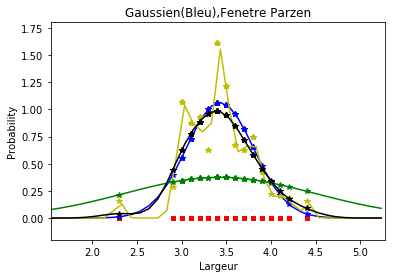

In [5]:

x_min=np.min(iris_train1d)-np.min(iris_train1d)/3;
x_max=np.max(iris_train1d)+np.max(iris_train1d)/5;
x=np.arange(x_min,x_max,0.1)

# utiliser estimateur_gaussien
classg1=gauss_mv(n_dims=1,cov_type="diagonale")
classg1.train(iris_train1d)

g1y1=classg1.pdf_normfun(x, classg1.mu, np.sqrt(classg1.sigma_sq))
g1y2 = classg1.pdf_normfun(iris_train1d, classg1.mu, np.sqrt(classg1.sigma_sq))

# utiliser estimateur_parzen
# avec un sigma trop petit
classp1=estimateur_parzen_a_noyau_gauss_mv_isotropique(1,sigma=0.05)
classp1.train(iris_train1d,iris_train1d_class)
p1y1=classp1.pdf_parzenfun(x, classp1.sigma, iris_train1d);
p1y2 = classp1.pdf_parzenfun(iris_train1d, classp1.sigma,iris_train1d);
# avec un sigma trop grand
classp2=estimateur_parzen_a_noyau_gauss_mv_isotropique(1,sigma=1)
classp2.train(iris_train1d,iris_train1d_class)
p2y1=classp2.pdf_parzenfun(x, classp2.sigma, iris_train1d);
p2y2 = classp2.pdf_parzenfun(iris_train1d, classp2.sigma,iris_train1d);
# avec un sigma hyper-paramètre que nous jugons plus approprié
classp3=estimateur_parzen_a_noyau_gauss_mv_isotropique(1,sigma=0.2)
classp3.train(iris_train1d,iris_train1d_class)
p3y1=classp1.pdf_parzenfun(x, classp3.sigma, iris_train1d);
p3y2 = classp1.pdf_parzenfun(iris_train1d, classp3.sigma,iris_train1d);

plt.xlim(x_min,x_max)
plt.ylim(-0.2, 1.8)
plt.scatter(iris_train1d, np.zeros(iris_train1d.shape), c='r',marker = 's', s=10)

# dessin les point vient de estimateur_gaussien
plt.plot(x,g1y1,'b')
plt.plot(iris_train1d,g1y2,'b*')
# dessin les point vient de estimateur_parzen
plt.plot(x,p1y1,'y')
plt.plot(iris_train1d,p1y2,'y*')
plt.plot(x,p2y1,'g')
plt.plot(iris_train1d,p2y2,'g*')
plt.plot(x,p3y1,'k')
plt.plot(iris_train1d,p3y2,'k*')

plt.title('Gaussien(Bleu),Fenetre Parzen')
plt.xlabel('Largeur')
plt.ylabel('Probability')
pylab.show()


### 4) Densites 2D : Ajoutez maintenant un second trait caracteristique d’iris, afin d’avoir des entrees en dimension d = 2 et produisez 4 graphiques, chacun affichant les points du sous-ensemble de donnees (avec la fonction plot), et les lignes de contours de la densite estimee (à l’aide de la fonction contour) suivante : 

(a) par votre estimateur parametrique Gaussien diagonal

(b) par l’estimateur de Parzen avec un hyper-parametre σ (écart type) trop petit

(c) par l’estimateur de Parzen avec un hyper-parametre σ un peu trop grand

(d) par l’estimateur de Parzen avec un hyper-parametre σ que vous jugerez plus approprié.

In [6]:

# choisir classe=1 pour demonstration
train_cols = [1,2,4]
iris_train2d = iris[iris[:,-1]==1][:,train_cols]
iris_train2d_class=iris_train2d[:,-1]
iris_train2d = iris_train2d[:,[0,1]]

In [7]:
n_points=100
x_min=np.min(iris_train2d[:,0]) -np.min(iris_train2d[:,0])/40;
x_max=np.max(iris_train2d[:,0]) +np.max(iris_train2d[:,0])/40;
y_min=np.min(iris_train2d[:,1]) -np.min(iris_train2d[:,1])/40;
y_max=np.max(iris_train2d[:,1]) +np.max(iris_train2d[:,1])/40;
xgrid = np.linspace(x_min, x_max, n_points)
ygrid = np.linspace(y_min, y_max, n_points)
thegrid = numpy.array(utilitaires.combine(xgrid,ygrid))
X,Y = np.meshgrid(xgrid, ygrid)


mu:  [ 3.428  1.462]
sigma_sq:  [ 0.140816  0.029556]


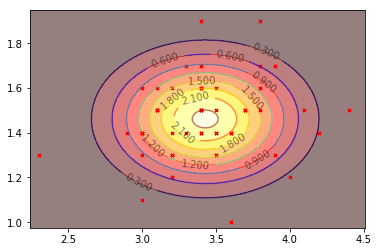

In [8]:
# utiliser estimateur_gaussien
classg1=gauss_mv(n_dims=2,cov_type="diagonale")
classg1.train(iris_train2d)
g1z1=classg1.pdf_normfun(thegrid, classg1.mu, np.sqrt(classg1.sigma_sq)).reshape((n_points, n_points)).T
g1z2 = classg1.pdf_normfun(iris_train2d, classg1.mu, np.sqrt(classg1.sigma_sq))
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
c = plt.contour(X,Y,g1z1,8,alpha=0.5,cmap=plt.cm.jet)
plt.contourf(X,Y,g1z1,8,alpha=0.5,cmap=plt.cm.hot)
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.scatter(iris_train2d[:,0], iris_train2d[:,1], c='r',marker = 'x', s=10)
#plt.contour(iris_train2d[:,0],iris_train2d[:,1],g1z2,8,alpha=0.5,cmap=plt.cm.jet)
plt.show()

#utilitaires.gridplot(classg1,iris_train2d,iris_train2d,n_points=100)

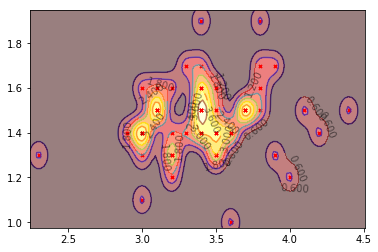

In [9]:

# utiliser estimateur_parzen
# avec un sigma trop petit
classp1=estimateur_parzen_a_noyau_gauss_mv_isotropique(2,sigma=0.05)
classp1.train(iris_train2d,iris_train2d_class)
p1z1=classp1.pdf_parzenfun(thegrid, classp1.sigma, iris_train2d).reshape((n_points, n_points)).T
p1z2 = classp1.pdf_parzenfun(iris_train2d, classp1.sigma,iris_train2d);

c = plt.contour(X,Y,p1z1,8,alpha=0.5,cmap=plt.cm.jet)
plt.contourf(X,Y,p1z1,8,alpha=0.5,cmap=plt.cm.hot)
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.scatter(iris_train2d[:,0], iris_train2d[:,1], c='r',marker = 'x', s=10)
#plt.contour(iris_train2d[:,0],iris_train2d[:,1],g1z2,8,alpha=0.5,cmap=plt.cm.jet)
plt.show()


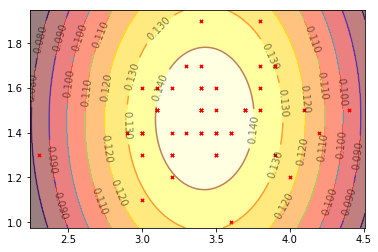

In [10]:


# avec un sigma trop grand
classp2=estimateur_parzen_a_noyau_gauss_mv_isotropique(2,sigma=1)
classp2.train(iris_train2d,iris_train2d_class)
p2z1=classp2.pdf_parzenfun(thegrid, classp2.sigma, iris_train2d).reshape((n_points, n_points)).T
p2z2 = classp2.pdf_parzenfun(iris_train2d, classp2.sigma,iris_train2d);

c = plt.contour(X,Y,p2z1,8,alpha=0.5,cmap=plt.cm.jet)
plt.contourf(X,Y,p2z1,8,alpha=0.5,cmap=plt.cm.hot)
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.scatter(iris_train2d[:,0], iris_train2d[:,1], c='r',marker = 'x', s=10)
#plt.contour(iris_train2d[:,0],iris_train2d[:,1],g1z2,8,alpha=0.5,cmap=plt.cm.jet)
plt.show()


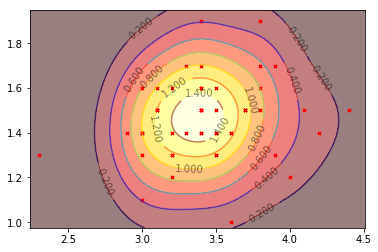

In [11]:

# avec un sigma hyper-paramètre que nous jugons plus approprié
classp3=estimateur_parzen_a_noyau_gauss_mv_isotropique(2,sigma=0.2)
classp3.train(iris_train2d,iris_train2d_class)
p3z1=classp1.pdf_parzenfun(thegrid, classp3.sigma, iris_train2d).reshape((n_points, n_points)).T
p3z2 = classp1.pdf_parzenfun(iris_train2d, classp3.sigma,iris_train2d);

c = plt.contour(X,Y,p3z1,8,alpha=0.5,cmap=plt.cm.jet)
plt.contourf(X,Y,p3z1,8,alpha=0.5,cmap=plt.cm.hot)
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.clabel(c,inline=True,fontsize=10,colors='k')
plt.scatter(iris_train2d[:,0], iris_train2d[:,1], c='r',marker = 'x', s=10)
#plt.contour(iris_train2d[:,0],iris_train2d[:,1],g1z2,8,alpha=0.5,cmap=plt.cm.jet)
plt.show()